In [42]:
import numpy as np
import os
from datetime import datetime, timedelta
import copy
from matplotlib import pyplot as plt

In [2]:
folders = os.listdir("data")
folders.remove(".DS_Store")
def filter_files(direct):
    sub_dir = "data/" + direct
    sub_dir_files = os.listdir(sub_dir)
    try:
        sub_dir_files.remove(".DS_Store")
    except:
        pass
    for sub_dir_file in sub_dir_files:
        fn = sub_dir + "/" + sub_dir_file
        f = open(fn, "r")
        true_false = False
        if direct != "duncan":
            for line in f:
                if "10/01/2015" not in line:
                    continue
                else:
                    true_false = True
        else:
            for line in f:
                if "2016" not in line:
                    continue
                else:
                    true_false = True
        if true_false == False:
            os.remove(fn)

In [3]:
def site_metadata(direct):
    sub_dir = "data/" + direct + "/"
    sub_dir_files = os.listdir(sub_dir)
    try:
        sub_dir_files.remove(".DS_Store")
    except:
        pass
    
    for sub_dir_file in sub_dir_files:
        fn = sub_dir + "/" + sub_dir_file
        f = open(fn, "r")
        print fn
        length = 0
        for line in f:
            if line[0] == "~":
                continue
            else:
                line_list = line.split(",")
                length_new = len(line_list)
                if length_new != length and length_new >= 10:
                    print length_new
                    print line
                    length = length_new

Caples is really messy, has a lot of weird code. This whole site has to be treated differently
For other sites, there are two starting mode, 12 or 14
For 12, first parse the time and date. Then parse temperature(3), rh(4), snow depth(-1)
For 14, first parse the time and date. Then parse temperature(3), rh(4), solar radiation(-1), snow depth(-2)

For now, beartrap and duncan data cannot be used
mt probably need some special algorithm to treat

alpha: good

bear:
00_17_0d_00_00_38_28_66.txt
00_17_0d_00_00_38_29_de.txt

caples:
00_17_0d_00_00_38_29_46.txt

duncan:
dump all

echo:
good

mt:
00_17_0d_00_00_38_3c_70.txt

onion:
00_17_0d_00_00_38_29_f7.txt

robb:
good

#### Please note that the cleaning of rh has not been defined since no problem has observed from the current data

In [233]:
def parse_site(site, 
               start_year, start_month, start_day, 
               clean_volt=False, 
               clean_snow=False, 
               clean_temp=False, 
               clean_rh=False,
               clean_solar=False):
    fault_nodes = {"alpha":[], "bear":["00_17_0d_00_00_38_28_66.txt", "00_17_0d_00_00_38_29_de.txt"],
               "caples":["00_17_0d_00_00_38_29_46.txt"], "echo":[], "mt":["00_17_0d_00_00_38_3c_70.txt"],
               "onion":["00_17_0d_00_00_38_29_f7.txt"], "robb":[]}
    sub_dir = "data/" + site + "/"
    sub_dir_files = os.listdir(sub_dir)
    try:
        sub_dir_files.remove(".DS_Store")
    except:
        pass
    
    # Create a datetime array that is of our interest, the base time and diff is adjustable
    base = datetime(start_year, start_month, start_day)
    diff = ((datetime.now() - base).days * 24 * 60) / 15
    datetime_array = np.array([base + timedelta(minutes=15*i) for i in range(diff)])
    print datetime_array
    
    # initiate all the variables we measure, all elements in the table should be nan
    snowdepth = np.empty((len(datetime_array), len(sub_dir_files)))
    snowdepth[:, :] = np.nan
    voltage = copy.deepcopy(snowdepth)
    temperature = copy.deepcopy(snowdepth)
    relative_humidity = copy.deepcopy(snowdepth)
    solar_radiation = copy.deepcopy(snowdepth)
    
    # start loop through the nodes
    for i, sub_dir_file in enumerate(sub_dir_files):
        fn = sub_dir + sub_dir_file
        print "Start processing " + fn
        f = open(fn, "r")
        
        # initialize the mode of the data as 12
        mode = 12
        
        # initialize a visiting array to check if the 
        visit = np.zeros(len(datetime_array))
        
        # Start processing each line of the data from the file
        for line in f:
            
            # Filter out the row starting with "~" 
            # this line of data is just recording the meta information of the node
            if line[0] == "~":
                continue
            
            else:
                line_list = line.split(",")
                length_new = len(line_list)
                
                # Only use the rows whose length is larger or equal to 10
                if length_new >= 10:
                    
                    # Some data starting with the mode of 14, detect them, if they change to 14
                    # keep using them
                    if length_new == 14 and mode == 12 :
                        mode = 14
                        
                    # Try split the data string and parse the first two items
                    # If failed, continue to the next row of data
                    try:
                        time_str = line_list[0].split(":")
                        date_str = line_list[1].split("/")
                        line_datetime = datetime(int(date_str[2]), int(date_str[0]), int(date_str[1]),
                                            int(time_str[0]), int(time_str[1], int(time_str[2])))
                    except:
                        continue
                    
                    # Calculate the index of the data in the matrix
                    t_index = int(((line_datetime - base).total_seconds())) / 60 / 15
                    
                    if t_index >= len(datetime_array):
                        continue
                    if t_index < 0 or visit[t_index] == 1:
                        continue
                    visit[t_index] == 1
                    try:
                        voltage[t_index, i] = float(line_list[2])
                    except:
                        pass
                    try:
                        temperature[t_index, i] = float(line_list[3])
                    except:
                        pass
                    try:
                        relative_humidity[t_index, i] = float(line_list[4])
                    except:
                        pass
                    if mode == 12:
                        try:
                            snowdepth[t_index, i] = float(line_list[-1])
                        except:
                            pass
                    else:
                        try:
                            snowdepth[t_index, i] = float(line_list[-2])
                        except:
                            pass
                        try:
                            solar_radiation[t_index, i] = float(line_list[-1])
                        except:
                            pass
                        
    # Start cleaning the voltage data in the voltage variable if the input clean_volt = True
    if clean_volt:
        for i in range(len(sub_dir_files)):
            print sub_dir_files[i]
            temp_volt = voltage[:, i]
            plt.figure(figsize=(10, 5))
            plt.plot(datetime_array, temp_volt, ".r")
            plt.xlim([np.min(datetime_array), np.max(datetime_array)])
#             plt.ylim([0, 15])
            plt.show()
            
    # Start cleaning the temperature data in the temperature variable if the input clean_temp = True
    if clean_temp:
        for i in range(len(sub_dir_files)):
            temp_temp = temperature[:, i]
            temp_temp[temp_temp >= 100.] = np.nan
            temp_temp[temp_temp <= -30.] = np.nan
            temperature[:, i] = temp_temp
    
    # Start cleaning the rh data in the relative_humidity variable if the input clean_rh = True
    
    # Left undefined, have not 
    
    if clean_rh:
        for i in range(len(sub_dir_files)):
            temp_rh = relative_humidity[:, i]
            
    # Start cleaning the solar data in the solar_radiation variable if the input clean_temp = True
    if clean_solar:
        for i in range(len(sub_dir_files)):
            print sub_dir_files[i]
            temp_solar = solar_radiation[:, i]
            plt.figure(figsize=(10, 5))
            plt.plot(datetime_array, temp_solar, ".r")
            plt.xlim([np.min(datetime_array), np.max(datetime_array)])
            plt.show()
            
    
    # Start cleaning the snow depth data in the snowdepth variable if the input clean_snow = True
    if clean_snow:
        snowdepth[snowdepth <= 600] = np.nan
        for i in range(len(sub_dir_files)):
            if sub_dir_files[i] in fault_nodes[site]:
                snowdepth[:, i] = np.nan
                continue
            else:
                print sub_dir_files[i]
                temp_snow = snowdepth[:, i]
                not_nan = ~np.isnan(temp_snow)
                not_nan_snowdepth = temp_snow[not_nan]
                if len(not_nan_snowdepth) > 10:
                    hist, bin_edges = np.histogram(not_nan_snowdepth, bins=np.arange(np.min(not_nan_snowdepth), 
                                                                                     np.max(not_nan_snowdepth), 10))
                    bin_edges = bin_edges[1:]
                    baseline = bin_edges[hist>30][-1]
                    not_nan_snowdepth = baseline - not_nan_snowdepth
                    snowdepth[not_nan, i] = not_nan_snowdepth
                else:
                    snowdepth[:, i] = np.nan
                    continue
            temp_snow = snowdepth[:, i]
            for j, point_snow in enumerate(temp_snow):
                if ~np.isnan(point_snow):
                    prev_points = temp_snow[:j]
                    if len(prev_points) > 0:
                        last_nan_idx = np.where(~np.isnan(prev_points))[0]
                        if len(last_nan_idx) == 0:
                            continue
                        last_nan_idx = last_nan_idx[-1]
                        prev_points = prev_points[~np.isnan(prev_points)]
                        if len(prev_points) > 0:
                            prev_point = prev_points[-1]
                            if np.absolute(point_snow - prev_point) >= 100 and (j - last_nan_idx) <= 10:
                                temp_snow[j] = np.nan
                            elif np.absolute(point_snow - prev_point) >= 400 and (j - last_nan_idx) <= 100:
                                temp_snow[j] = np.nan
                        else:
                            continue
                    else:
                        continue
            temp_snow[temp_snow <= -50.] = np.nan
        save_fn = site+"_snowdepth.npy"
        save_time_fn = site+"_time.npy"
        np.save(save_fn, snowdepth)
        np.save(save_time_fn, datetime_array)

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/alpha/00_17_0d_00_00_38_3a_be.txt
Start processing data/alpha/00_17_0d_00_00_38_3b_8a.txt
Start processing data/alpha/00_17_0d_00_00_38_3b_d0.txt
Start processing data/alpha/00_17_0d_00_00_38_3c_19.txt
Start processing data/alpha/00_17_0d_00_00_38_3c_71.txt
Start processing data/alpha/00_17_0d_00_00_38_3d_4e.txt
Start processing data/alpha/00_17_0d_00_00_60_17_38.txt
00_17_0d_00_00_38_3a_be.txt


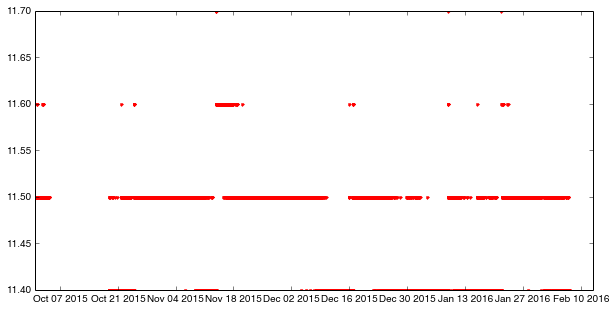

00_17_0d_00_00_38_3b_8a.txt


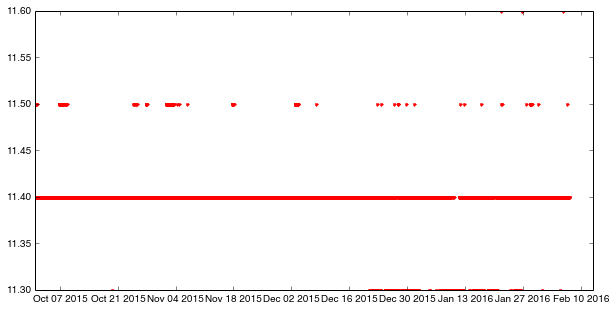

00_17_0d_00_00_38_3b_d0.txt


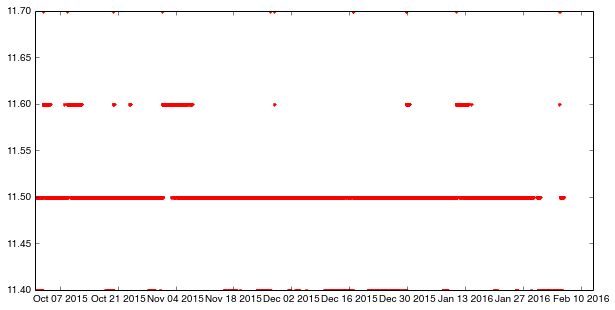

00_17_0d_00_00_38_3c_19.txt


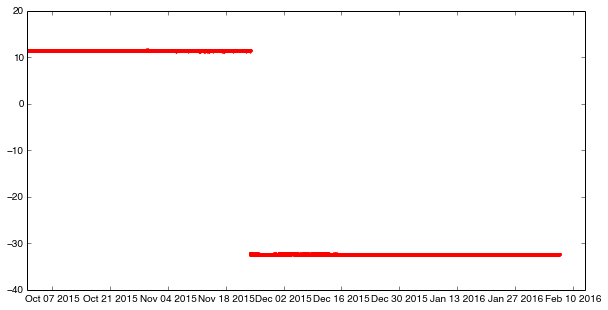

00_17_0d_00_00_38_3c_71.txt


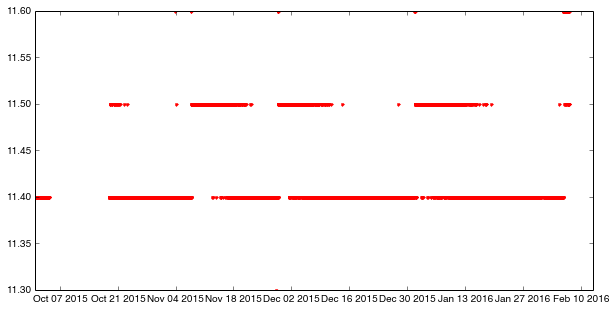

00_17_0d_00_00_38_3d_4e.txt


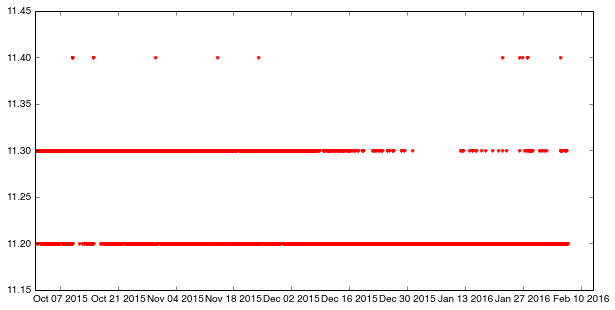

00_17_0d_00_00_60_17_38.txt


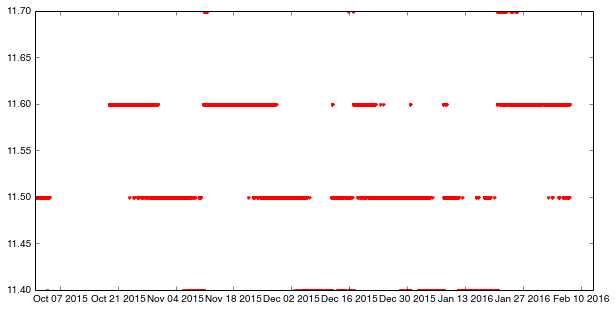

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/bear/00_17_0d_00_00_38_28_66.txt
Start processing data/bear/00_17_0d_00_00_38_29_cd.txt
Start processing data/bear/00_17_0d_00_00_38_29_de.txt
Start processing data/bear/00_17_0d_00_00_38_3a_bd.txt
Start processing data/bear/00_17_0d_00_00_38_3c_6d.txt
00_17_0d_00_00_38_28_66.txt


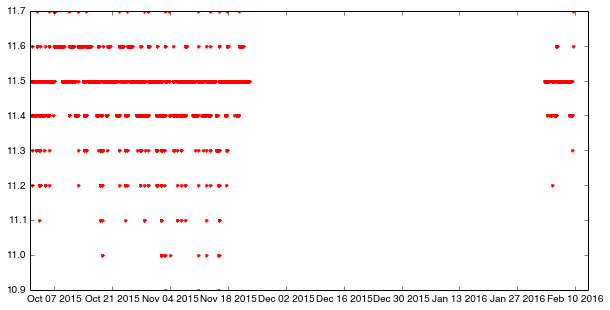

00_17_0d_00_00_38_29_cd.txt


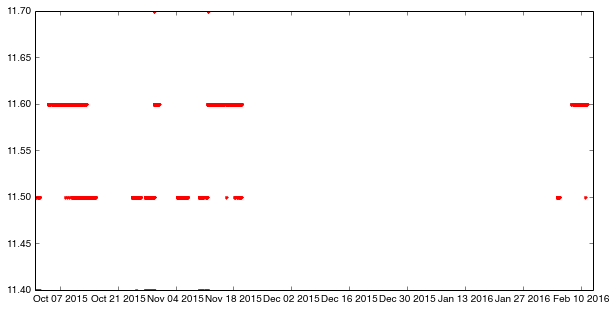

00_17_0d_00_00_38_29_de.txt


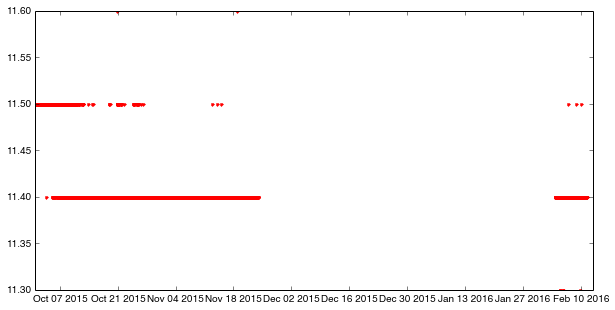

00_17_0d_00_00_38_3a_bd.txt


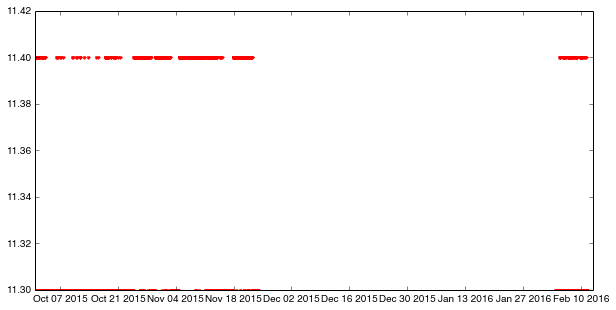

00_17_0d_00_00_38_3c_6d.txt


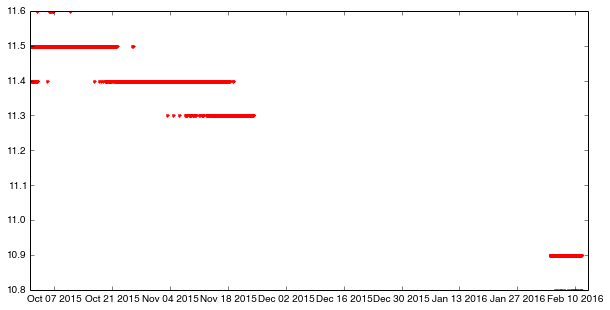

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/caples/00_17_0d_00_00_38_28_18.txt
Start processing data/caples/00_17_0d_00_00_38_28_f2.txt
Start processing data/caples/00_17_0d_00_00_38_29_1f.txt
Start processing data/caples/00_17_0d_00_00_38_29_46.txt
Start processing data/caples/00_17_0d_00_00_38_29_61.txt
Start processing data/caples/00_17_0d_00_00_38_35_1b.txt
Start processing data/caples/00_17_0d_00_00_38_35_1c.txt
Start processing data/caples/00_17_0d_00_00_38_39_86.txt
Start processing data/caples/00_17_0d_00_00_38_3b_ea.txt
Start processing data/caples/00_17_0d_00_00_60_24_f3.txt
00_17_0d_00_00_38_28_18.txt


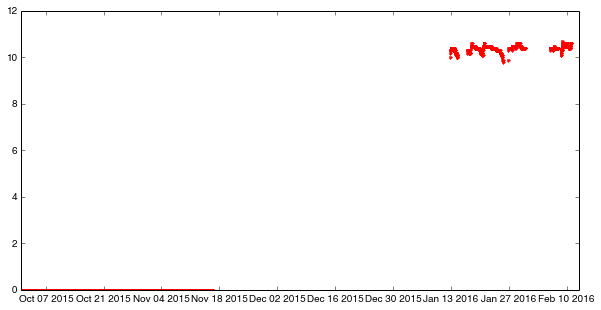

00_17_0d_00_00_38_28_f2.txt


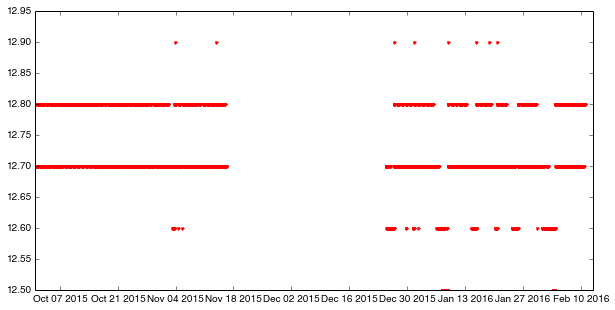

00_17_0d_00_00_38_29_1f.txt


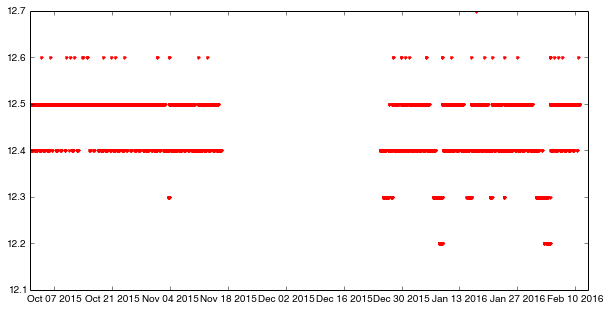

00_17_0d_00_00_38_29_46.txt


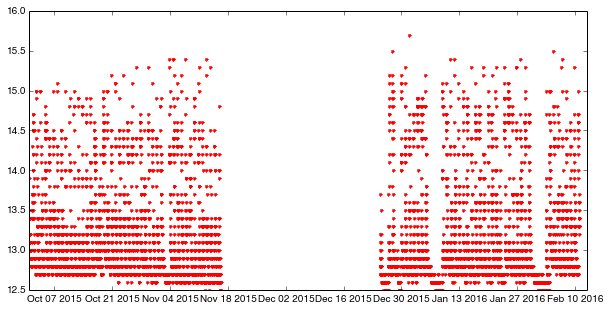

00_17_0d_00_00_38_29_61.txt


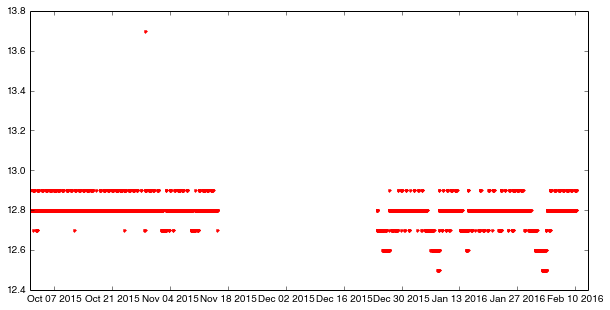

00_17_0d_00_00_38_35_1b.txt


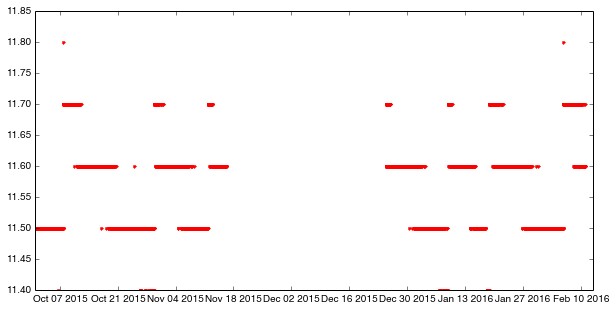

00_17_0d_00_00_38_35_1c.txt


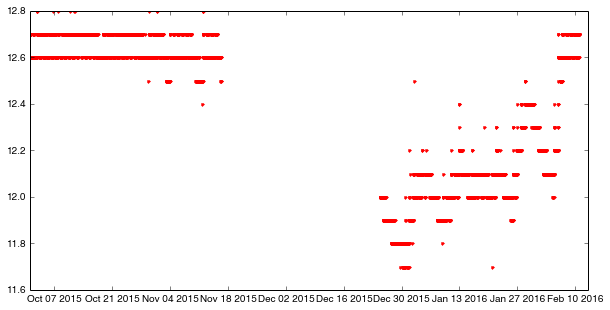

00_17_0d_00_00_38_39_86.txt


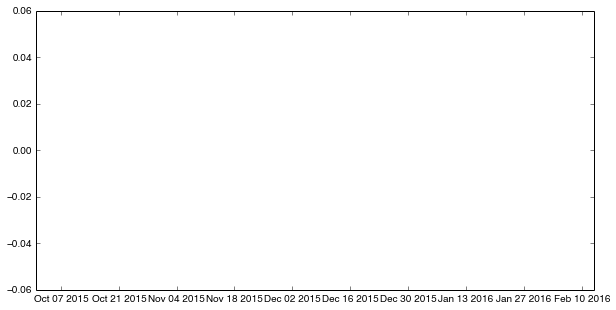

00_17_0d_00_00_38_3b_ea.txt


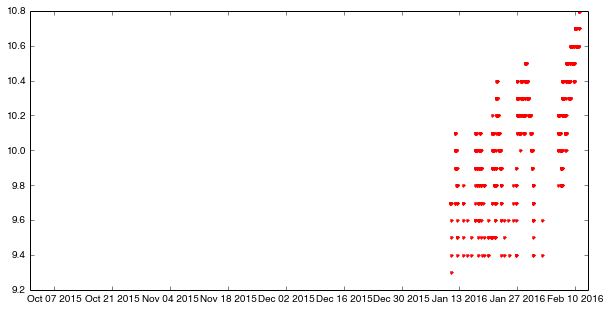

00_17_0d_00_00_60_24_f3.txt


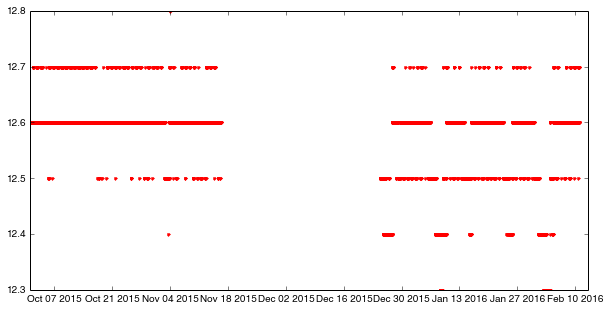

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/duncan/00_17_0d_00_00_38_28_28.txt
Start processing data/duncan/00_17_0d_00_00_38_28_30.txt
Start processing data/duncan/00_17_0d_00_00_38_28_55.txt
Start processing data/duncan/00_17_0d_00_00_38_28_5c.txt
Start processing data/duncan/00_17_0d_00_00_38_28_68.txt
Start processing data/duncan/00_17_0d_00_00_38_29_01.txt
Start processing data/duncan/00_17_0d_00_00_38_29_54.txt
Start processing data/duncan/00_17_0d_00_00_38_29_eb.txt
Start processing data/duncan/00_17_0d_00_00_38_2a_73.txt
Start processing data/duncan/00_17_0d_00_00_38_3a_e7.txt
Start processing data/duncan/00_17_0d_00_00_38_3b_88.txt
00_17_0d_00_00_38_28_28.txt


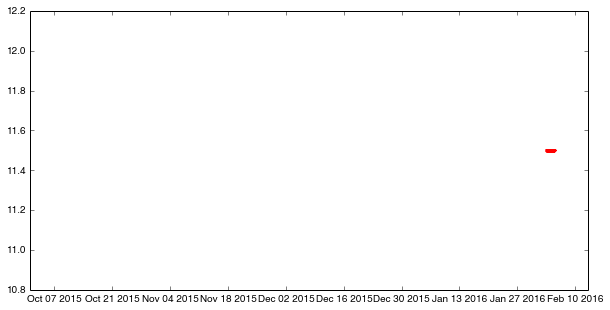

00_17_0d_00_00_38_28_30.txt


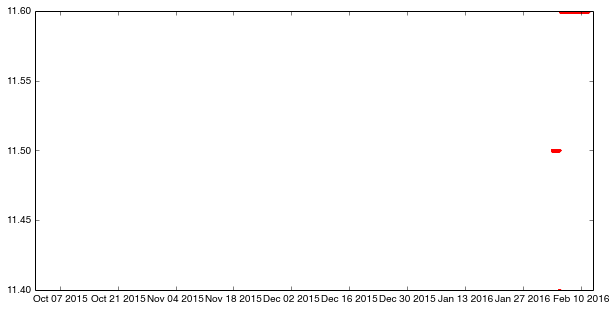

00_17_0d_00_00_38_28_55.txt


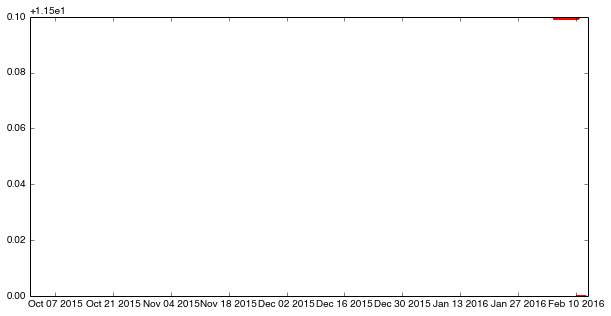

00_17_0d_00_00_38_28_5c.txt


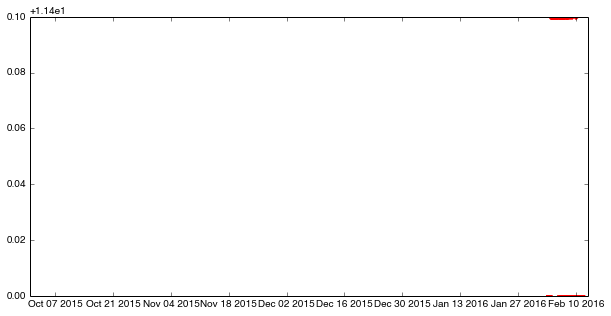

00_17_0d_00_00_38_28_68.txt


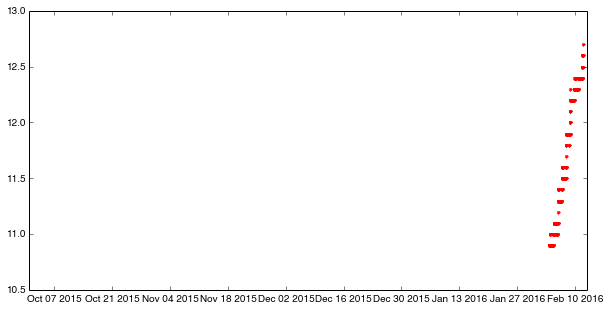

00_17_0d_00_00_38_29_01.txt


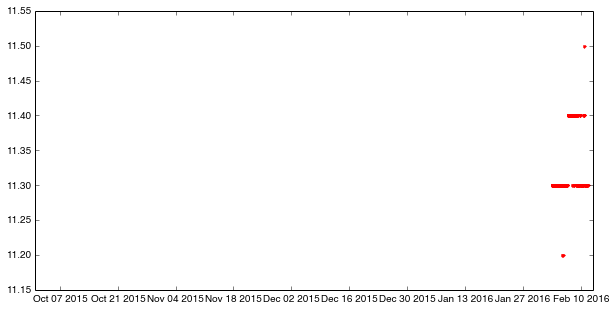

00_17_0d_00_00_38_29_54.txt


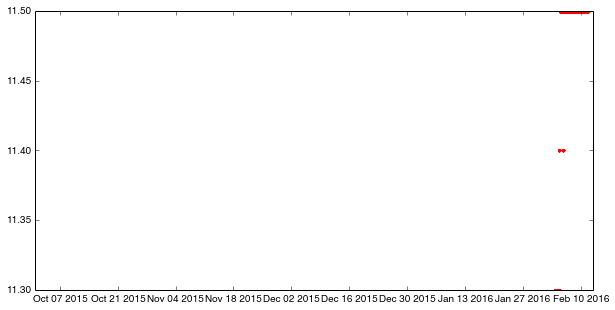

00_17_0d_00_00_38_29_eb.txt


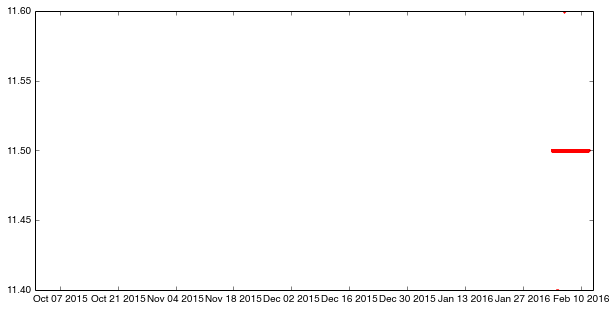

00_17_0d_00_00_38_2a_73.txt


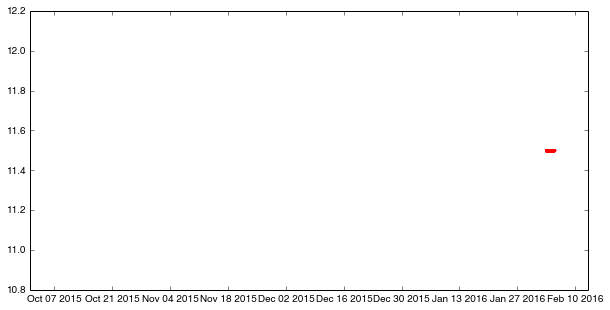

00_17_0d_00_00_38_3a_e7.txt


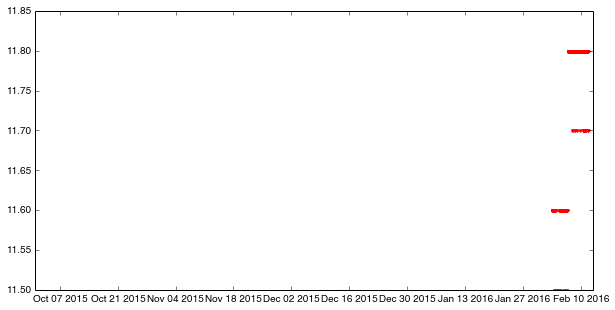

00_17_0d_00_00_38_3b_88.txt


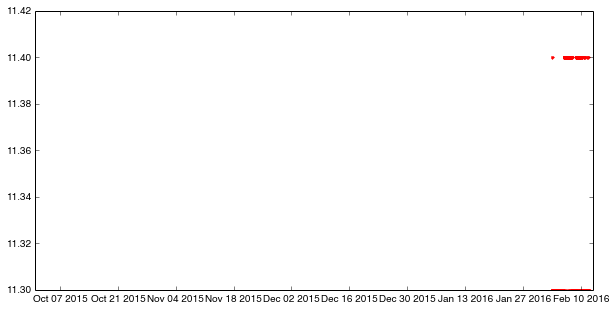

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/echo/00_17_0d_00_00_38_28_b1.txt
Start processing data/echo/00_17_0d_00_00_38_28_e0.txt
Start processing data/echo/00_17_0d_00_00_38_28_e6.txt
Start processing data/echo/00_17_0d_00_00_38_29_4c.txt
Start processing data/echo/00_17_0d_00_00_38_2a_11.txt
Start processing data/echo/00_17_0d_00_00_38_2a_77.txt
Start processing data/echo/00_17_0d_00_00_38_35_0f.txt
Start processing data/echo/00_17_0d_00_00_38_39_85.txt
Start processing data/echo/00_17_0d_00_00_38_3b_e2.txt
00_17_0d_00_00_38_28_b1.txt


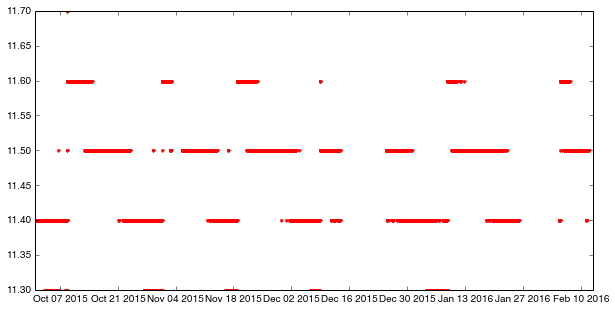

00_17_0d_00_00_38_28_e0.txt


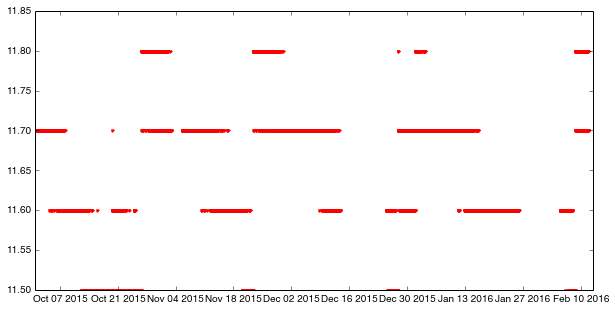

00_17_0d_00_00_38_28_e6.txt


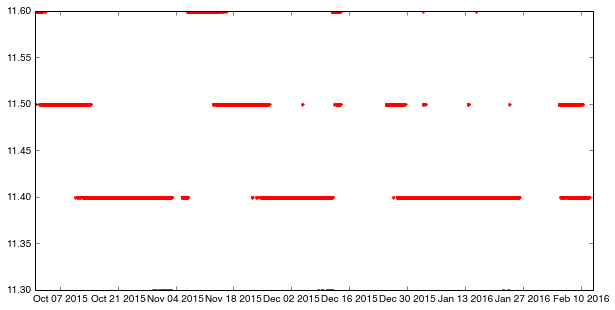

00_17_0d_00_00_38_29_4c.txt


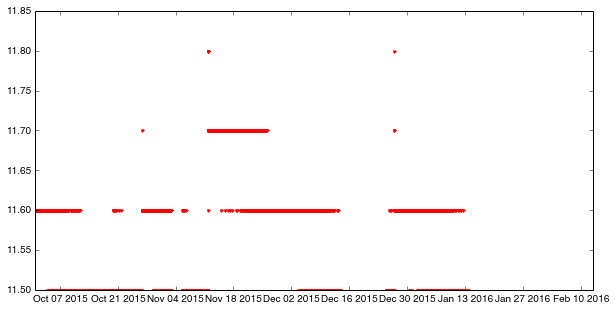

00_17_0d_00_00_38_2a_11.txt


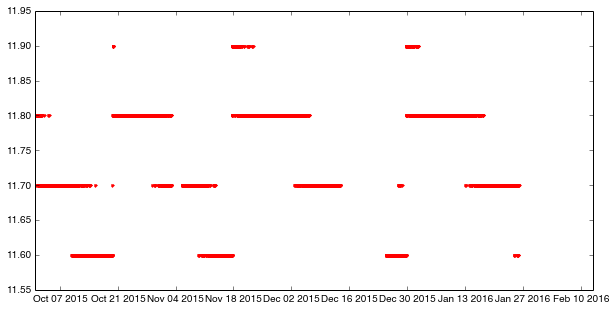

00_17_0d_00_00_38_2a_77.txt


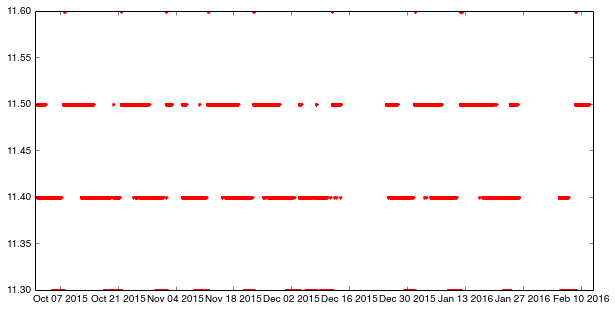

00_17_0d_00_00_38_35_0f.txt


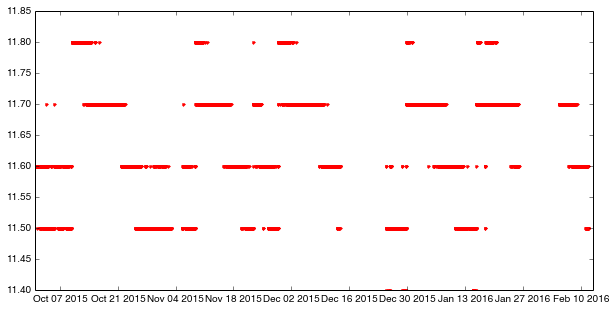

00_17_0d_00_00_38_39_85.txt


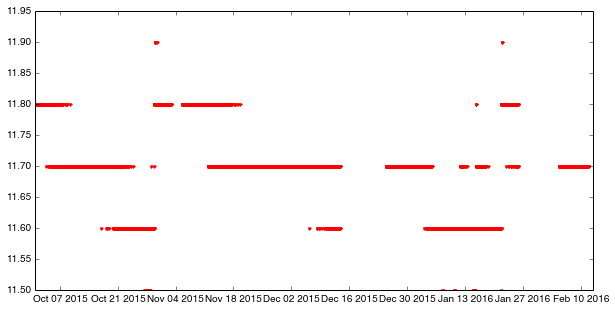

00_17_0d_00_00_38_3b_e2.txt


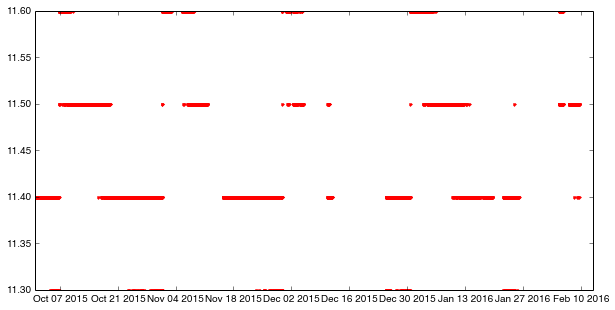

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/mt/00_17_0d_00_00_38_1f_53.txt
Start processing data/mt/00_17_0d_00_00_38_28_2b.txt
Start processing data/mt/00_17_0d_00_00_38_28_6e.txt
Start processing data/mt/00_17_0d_00_00_38_29_c2.txt
Start processing data/mt/00_17_0d_00_00_38_33_3b.txt
Start processing data/mt/00_17_0d_00_00_38_35_0a.txt
Start processing data/mt/00_17_0d_00_00_38_3c_70.txt
00_17_0d_00_00_38_1f_53.txt


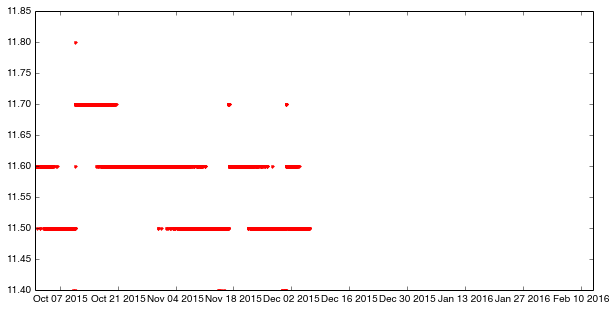

00_17_0d_00_00_38_28_2b.txt


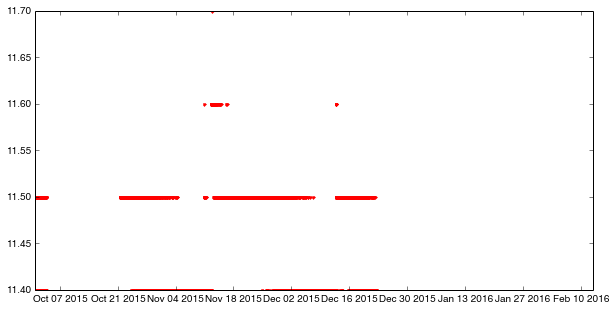

00_17_0d_00_00_38_28_6e.txt


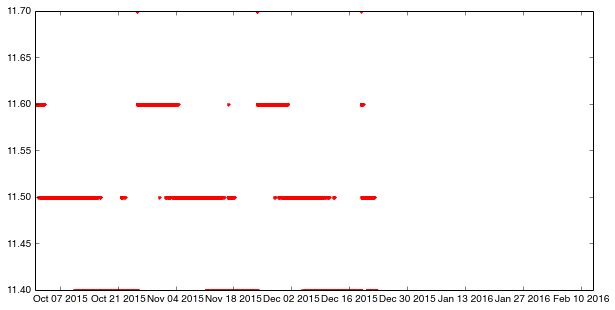

00_17_0d_00_00_38_29_c2.txt


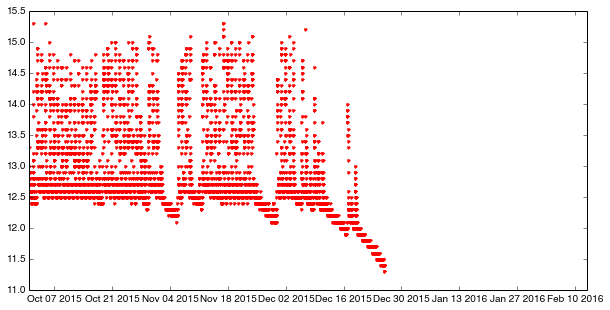

00_17_0d_00_00_38_33_3b.txt


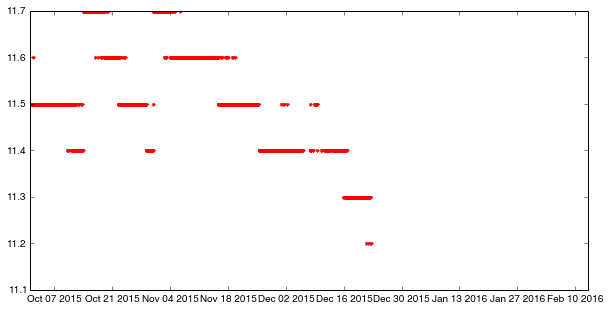

00_17_0d_00_00_38_35_0a.txt


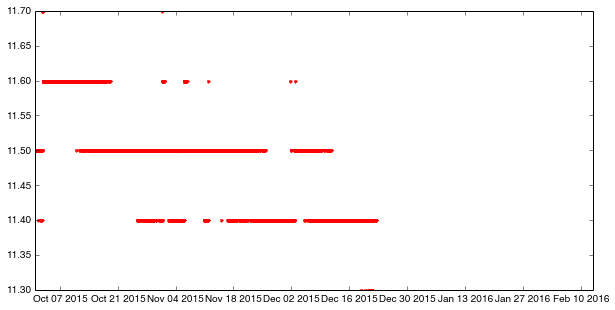

00_17_0d_00_00_38_3c_70.txt


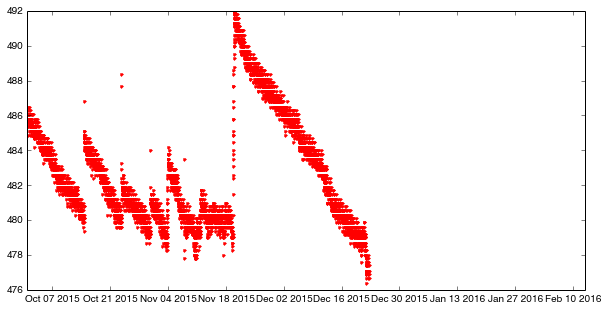

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/onion/00_17_0d_00_00_38_28_48.txt
Start processing data/onion/00_17_0d_00_00_38_29_66.txt
Start processing data/onion/00_17_0d_00_00_38_29_f7.txt
Start processing data/onion/00_17_0d_00_00_38_2a_30.txt
Start processing data/onion/00_17_0d_00_00_38_3a_43.txt
Start processing data/onion/00_17_0d_00_00_38_3a_8f.txt
Start processing data/onion/00_17_0d_00_00_38_3b_35.txt
Start processing data/onion/00_17_0d_00_00_38_3e_18.txt
Start processing data/onion/00_17_0d_00_00_60_2b_a0.txt
00_17_0d_00_00_38_28_48.txt


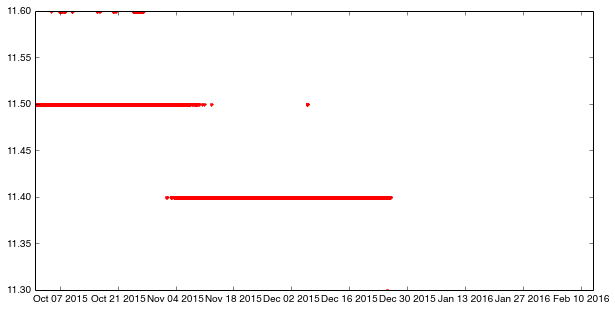

00_17_0d_00_00_38_29_66.txt


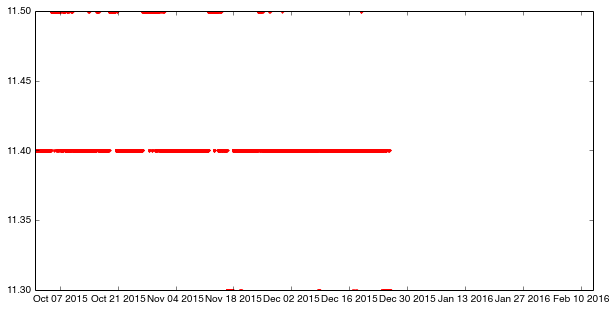

00_17_0d_00_00_38_29_f7.txt


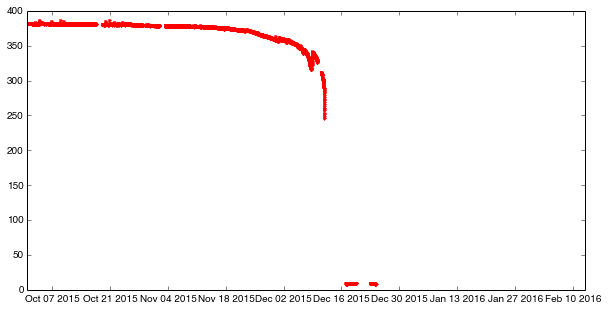

00_17_0d_00_00_38_2a_30.txt


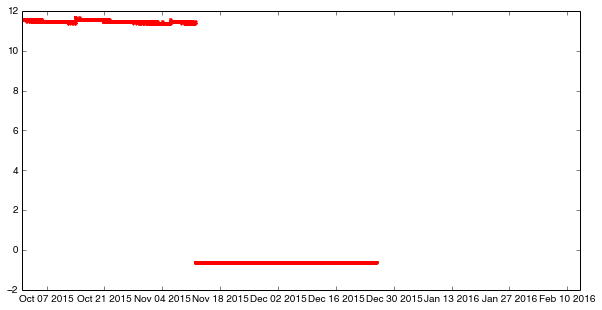

00_17_0d_00_00_38_3a_43.txt


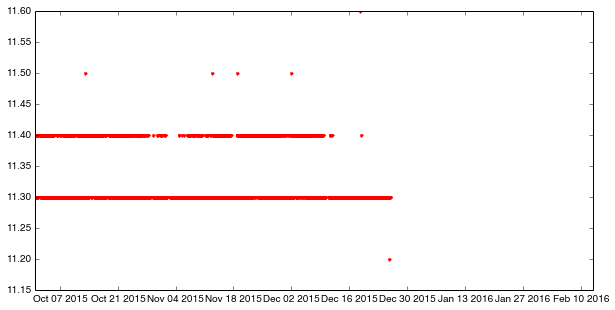

00_17_0d_00_00_38_3a_8f.txt


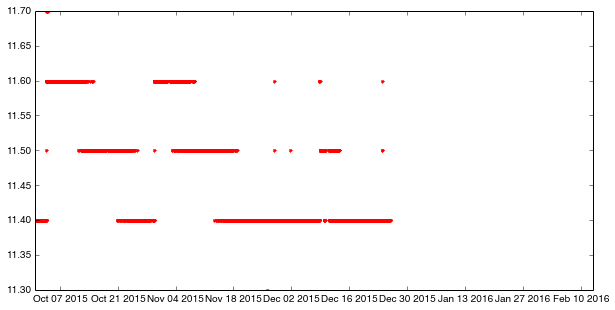

00_17_0d_00_00_38_3b_35.txt


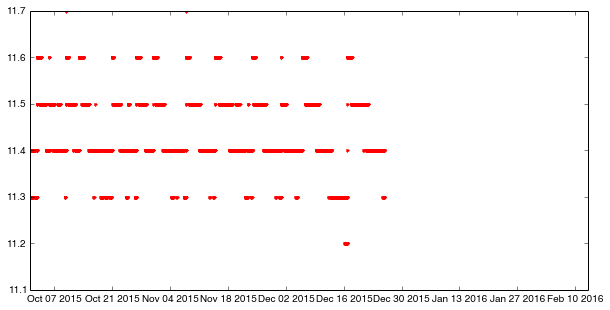

00_17_0d_00_00_38_3e_18.txt


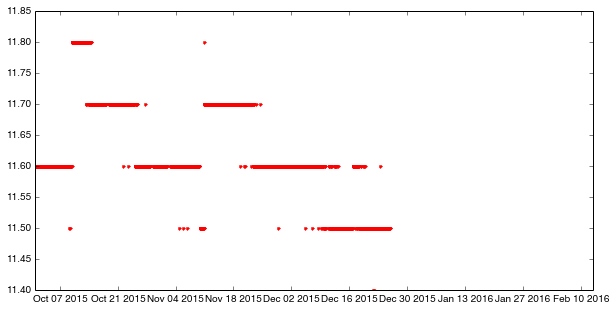

00_17_0d_00_00_60_2b_a0.txt


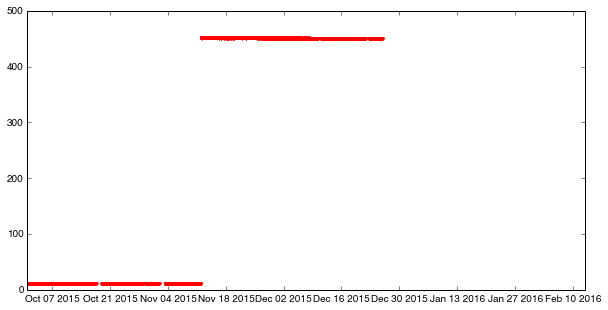

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 12, 23, 15)
 datetime.datetime(2016, 2, 12, 23, 30)
 datetime.datetime(2016, 2, 12, 23, 45)]
Start processing data/robb/00_17_0d_00_00_38_29_d5.txt
Start processing data/robb/00_17_0d_00_00_38_29_d7.txt
Start processing data/robb/00_17_0d_00_00_38_29_f8.txt
Start processing data/robb/00_17_0d_00_00_38_2a_44.txt
Start processing data/robb/00_17_0d_00_00_38_33_43.txt
Start processing data/robb/00_17_0d_00_00_38_35_16.txt
Start processing data/robb/00_17_0d_00_00_38_3a_8e.txt
Start processing data/robb/00_17_0d_00_00_38_3b_20.txt
Start processing data/robb/00_17_0d_00_00_3f_f9_b0.txt
Start processing data/robb/00_17_0d_00_00_60_18_76.txt
00_17_0d_00_00_38_29_d5.txt


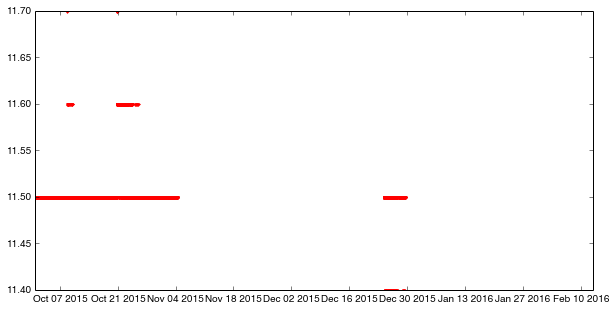

00_17_0d_00_00_38_29_d7.txt


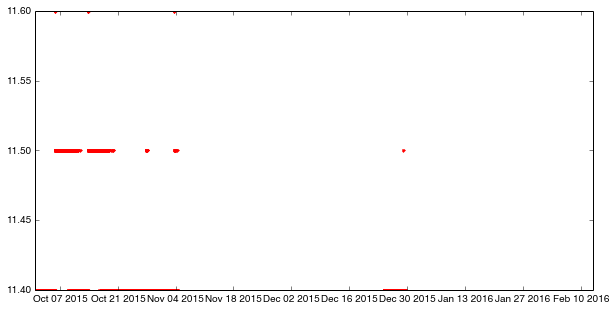

00_17_0d_00_00_38_29_f8.txt


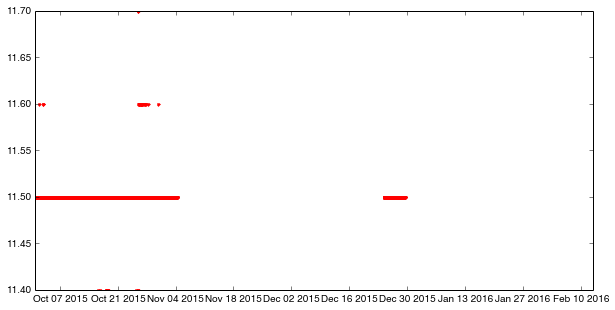

00_17_0d_00_00_38_2a_44.txt


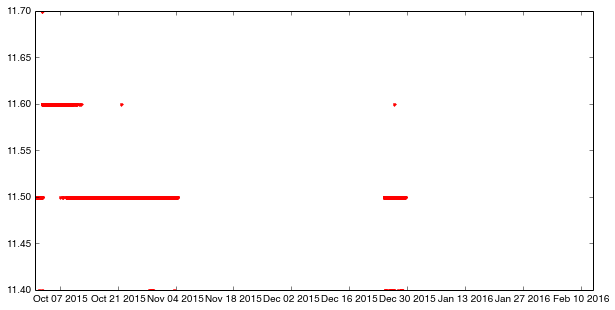

00_17_0d_00_00_38_33_43.txt


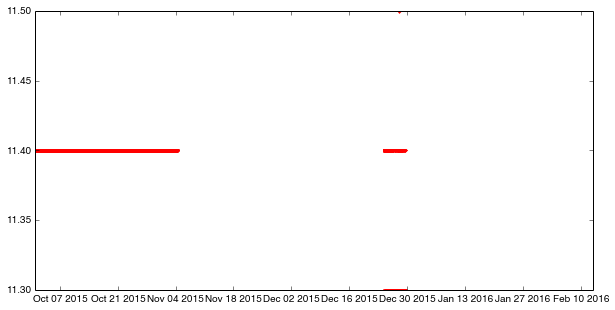

00_17_0d_00_00_38_35_16.txt


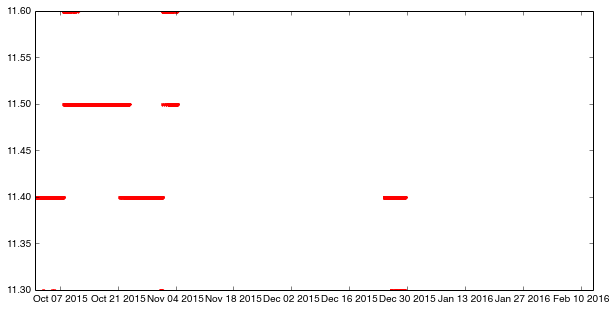

00_17_0d_00_00_38_3a_8e.txt


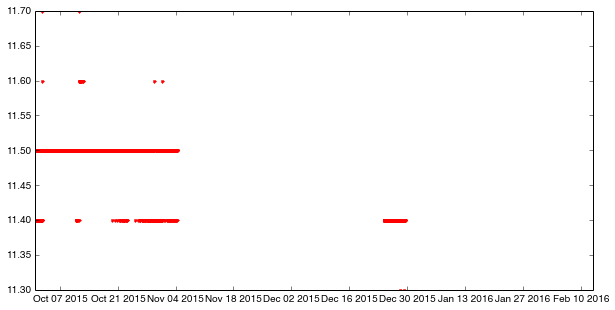

00_17_0d_00_00_38_3b_20.txt


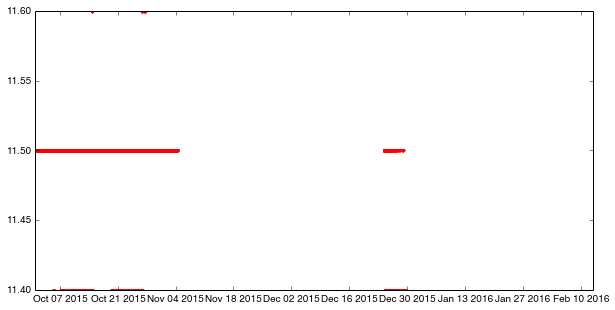

00_17_0d_00_00_3f_f9_b0.txt


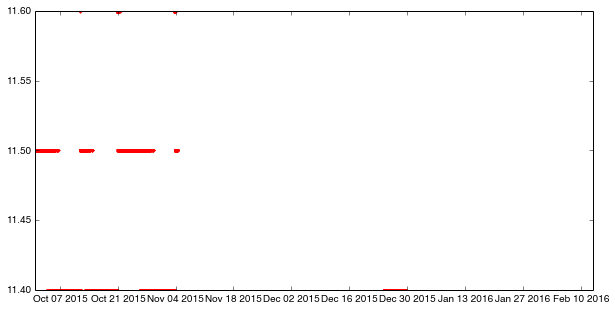

00_17_0d_00_00_60_18_76.txt


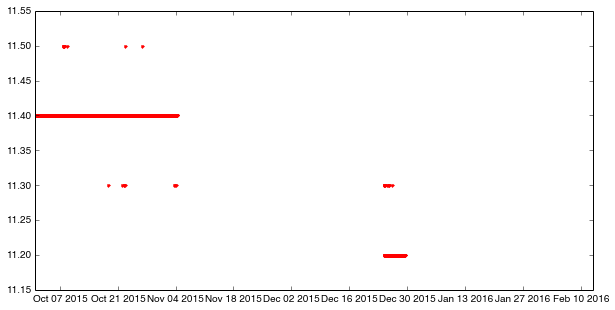

In [235]:
sites = ["alpha", "bear", "caples", "duncan", "echo", "mt", "onion", "robb"]
for site in sites:
    parse_site(site, 2015, 10, 1, clean_volt=True)

In [191]:
sites = ["alpha", "bear", "caples", "echo", "mt", "onion", "robb"]
for site in sites:
    parse_site(site, 2015, 10, 1)

[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 11, 23, 15)
 datetime.datetime(2016, 2, 11, 23, 30)
 datetime.datetime(2016, 2, 11, 23, 45)]
Start processing data/alpha/00_17_0d_00_00_38_3a_be.txt
Start processing data/alpha/00_17_0d_00_00_38_3b_8a.txt
Start processing data/alpha/00_17_0d_00_00_38_3b_d0.txt
Start processing data/alpha/00_17_0d_00_00_38_3c_19.txt
Start processing data/alpha/00_17_0d_00_00_38_3c_71.txt
Start processing data/alpha/00_17_0d_00_00_38_3d_4e.txt
Start processing data/alpha/00_17_0d_00_00_60_17_38.txt
00_17_0d_00_00_38_3a_be.txt
00_17_0d_00_00_38_3b_8a.txt
00_17_0d_00_00_38_3b_d0.txt
00_17_0d_00_00_38_3c_19.txt
00_17_0d_00_00_38_3c_71.txt
00_17_0d_00_00_38_3d_4e.txt
00_17_0d_00_00_60_17_38.txt
[datetime.datetime(2015, 10, 1, 0, 0) datetime.datetime(2015, 10, 1, 0, 15)
 datetime.datetime(2015, 10, 1, 0, 30) ...,
 datetime.datetime(2016, 2, 11, 23, 15)
 datetime.d

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:78: RuntimeWarning: invalid value encountered in less_equal


alpha
bear
caples
echo
mt
onion
robb


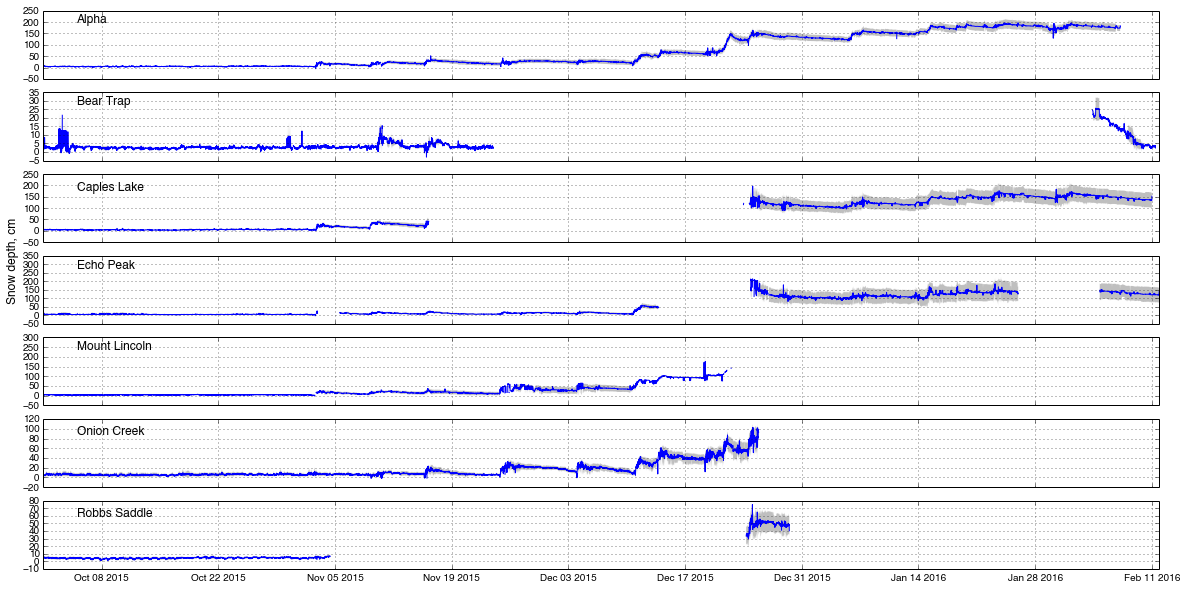

In [207]:
sites = ["alpha", "bear", "caples", "echo", "mt", "onion", "robb"]
y_loc = [200, 28, 180, 280, 240, 90, 60]
name = ["Alpha", "Bear Trap", "Caples Lake", "Echo Peak", "Mount Lincoln", "Onion Creek", "Robbs Saddle"]
fig, axarr = plt.subplots(ncols=1, nrows=len(sites), figsize=(20, 10), sharex=True)
for i, site in enumerate(sites):
    print site
    time_fn = site+"_time.npy"
    data_fn = site+"_snowdepth.npy"
    datetime_array = np.load(time_fn)
    snowdepth_array = np.load(data_fn)
    mean = np.nanmean(snowdepth_array, axis=1)
    mean = mean / 10.
    std = np.nanstd(snowdepth_array, axis=1)
    std = std / 10.
    axarr[i].plot(datetime_array, mean)
    axarr[i].fill_between(datetime_array, mean-std, mean+std, facecolor="grey", alpha=0.5, edgecolor="none")
    axarr[i].grid()
    axarr[i].text(datetime(2015, 10, 5), y_loc[i], name[i], fontsize=12)
fig.text(0.1, 0.6, "Snow depth, cm", rotation="vertical", fontsize=12)
plt.savefig("output.pdf")
plt.show()